In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [546]:
data = pd.read_csv("hs.csv")
data.head()

,tic,date,close,high,low,div,adjustment_factor
0,3,0 days,0.496216,0.496821,0.482894,NaN,1.0
1,3,1 days,0.586437,0.594914,0.506206,NaN,1.0
2,3,2 days,0.605510,0.611838,0.578868,NaN,1.0
3,3,5 days,0.604905,0.623675,0.591281,NaN,1.0
4,3,6 days,0.602483,0.607629,0.594914,NaN,1.0


In [547]:
# Firstly focus on 10 stocks
data = data[data["tic"] < 10]
data_1 = data.copy()
data_1["date"] = data["date"].apply(lambda x: int(x.split(" ")[0]))
data_1.sort_values(by="date")
data_1["adj_close"] = data_1["close"] / data_1["adjustment_factor"]

In [549]:
P = data_1.pivot(index = 'date', columns = 'tic', values = 'adj_close')
P.head()

tic,0,1,2,3,4,5,6,7,8,9
date,,,,,,,,,,
0,0.568334,0.028695,0.925028,0.496216,0.476190,1.181330,1.000000,1.321060,0.929495,0.437222
1,0.583588,0.029039,0.908027,0.586437,0.457509,1.151288,1.013373,1.342047,0.945353,0.436736
2,0.576571,0.029175,0.911093,0.605510,0.467427,1.155579,1.019532,1.388807,0.984630,0.443542
5,0.601891,0.028202,0.921126,0.604905,0.478983,1.168240,1.020940,1.384389,1.000244,0.438264
6,0.595790,0.027845,0.919732,0.602483,0.472339,1.137124,1.012141,1.364138,0.983899,0.431250


<AxesSubplot:xlabel='date'>

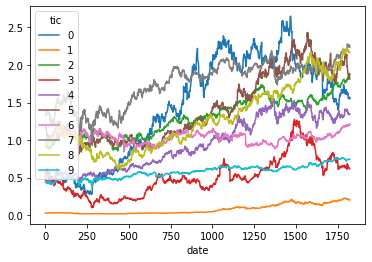

In [551]:
# Stocks' dynamics through time
P.plot()

<AxesSubplot:xlabel='date'>

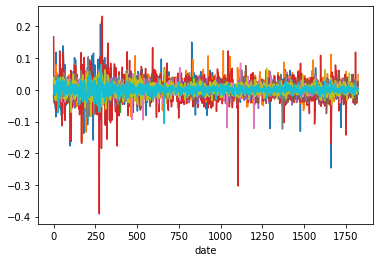

In [552]:
# log returns
DlogR = np.log(P).diff()
DlogR.plot(legend=False)

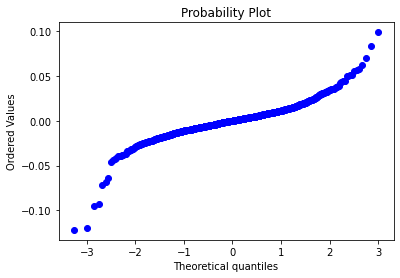

In [555]:
from scipy.stats import probplot
probplot(DlogR[6], plot = plt);

<AxesSubplot:xlabel='tic', ylabel='tic'>

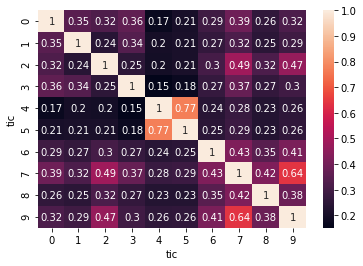

In [556]:
# Returns and their correlations
R = np.exp(DlogR)
sns.heatmap(R.corr(), annot=True)

In [768]:
# auxiliary functions

# exponentially weighted average
def ewma(arr):
    n = len(arr)
    coeffs = np.array([np.e**(i/2) for i in range(n)])
    summer = np.sum(coeffs)
    coeffs /= summer
    return arr@coeffs
    
# cov(R1,R2) = E[R1*R2] - E[R1]*E[R2]
def covariance(arr_1, arr_2):
    return ewma(arr_1 * arr_2) - ewma(arr_1) * ewma(arr_2)

# sqrt(pi^T * covariance_matrix * pi)
def standard_deviation(returns, strategy):
    number_of_assets = returns.shape[1]
    matrix = [[] for i in range(number_of_assets)]
#   constructing a covariance matrix
    for i in range(number_of_assets):
        for j in range(number_of_assets):   
            matrix[i].append(covariance(returns[i],returns[j]))
    return np.sqrt(strategy@matrix@strategy.T)

Implementing portfolio sharpe ratio maximization strategy

In [793]:

def calculate_sharpe_ratio(first_date, last_date, returns, strategy):
#   riskless annual mean return  
    risk_less_return = 0.04
#   calculating historical returns of the portfolio
    returns_of_the_strategy = np.array(returns[first_date:last_date]*strategy).sum(axis=1)
    mean_return = ewma(returns_of_the_strategy)
    
#   calculating historical std of the portfolio
    std_dev = standard_deviation(returns[first_date:last_date], strategy)
    
#   calculating sharpe ratio of the portfolio
    sharpe_ratio = (mean_return - np.e**(risk_less_return * 1/365)) / std_dev
    return sharpe_ratio

def backtest(wealth, returns, new_strategy, initial_step, number_of_steps):
#   allocated wealth
    allocation = wealth * new_strategy
    for i in range(number_of_steps):
        allocation = allocation * np.array(returns[initial_step+i:initial_step + i+1])[0]
    return np.array(allocation)    
    

In [837]:
from scipy.optimize import minimize 


def find_and_simulate_strategy(wealth, returns, commission_rate, first_step, step_size, smart_portfolio = True):
    returns = returns.dropna()
    history_check = step_size * 2
    wealths = []
    days = []
    number_of_assets = returns.shape[1]
    previous_allocation = np.array([0 for i in range(number_of_assets)])
    for i in range(first_step, len(returns), step_size):
        days.append(i)
        
#       How far in history we want to look to calculate a sharpe ratio
#         j = max(0, i - history_check)
        j = 0
        steps_to_make = min(step_size, len(returns) - step_size - i)
                
        portfolio_ratio_tilde = lambda x: -calculate_sharpe_ratio(j, i, returns, x)
        bnds = tuple([(0,1) for x in range(number_of_assets)])
        first_attempt = np.repeat(1/number_of_assets, number_of_assets)     
        if smart_portfolio:
            sol = minimize(portfolio_ratio_tilde, 
                           x0=first_attempt,
                           method= "trust-constr",
                           constraints={'type': 'ineq', 'fun': lambda x: -x@np.ones(number_of_assets)+1}, 
                           bounds = bnds,
                          tol = 10**-1)
            new_allocation = sol.x
        else: 
            new_allocation = first_attempt
#       commision for rebalancing
        net_commision = abs(wealth*new_allocation - previous_allocation).sum()*commission_rate
#       new wealth after rebalancing
        wealth -= net_commision
        step_final_allocation = backtest(wealth, returns, new_allocation, i, steps_to_make)
        previous_allocation = step_final_allocation
        wealth = step_final_allocation.sum()
        wealths.append(wealth)
    return wealths, days

/usr/local/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


278.94393946806906


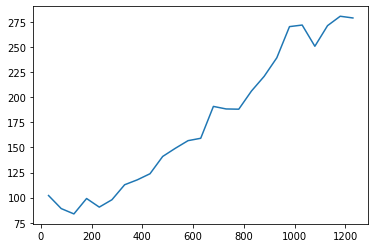

In [839]:
# Sharpe ratio maximized portfolio
wealths,days = find_and_simulate_strategy(100, R, 0.01, 30, 50)
plt.plot(days,wealths)
print(wealths[-1])

242.95673147697534


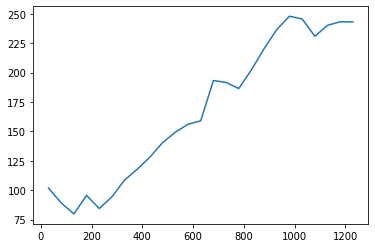

In [840]:
# Unifrom distributed portfolio choices
wealths,days = find_and_simulate_strategy(100, R, 0.01, 30, 50, False)
plt.plot(days,wealths)
print(wealths[-1])

[10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


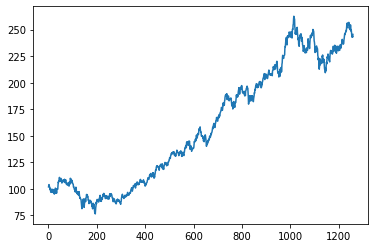

In [859]:
a = np.repeat(1/10, 10)*100
print(a)
l = []
j = []
for i in range(1,len(R)):
    a *= np.array(R[i:i+1])[0]
    l.append(a.sum())
    j.append(i)
# a.sum()
# print(l)
plt.plot(j,l)